In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 
%load_ext tensorboard

In [2]:
import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import tensorflow.keras.backend as kb
import yaml
import datetime
import glob

In [3]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [4]:
from HelperFn.ExpData_Generator import TrainingGenerator
from HelperFn.ExpData_Generator import EvalTestGenerator
from HelperFn.utils import Params
from sklearn.metrics import r2_score

In [5]:
# recommended params.json is included in run_1 folder, ready for demo run. 
# archive_final_run folder contain pre-trained model (best model)
mini_EXP_name = 'archive_final_run'
exp_folder_path = 'experiments/' + mini_EXP_name

DATA_DIR = '../../processed_input_data/'
NPY_FOLDER = 'slice_npy/'
ML_EXP = 'split_master/'
Train_Master = 'train_master.txt'
Eval_Master = 'eval_master.txt'
Test_Master = 'test_master.txt'
json_path = os.path.join(exp_folder_path, 'params.json')

In [6]:
params = Params(json_path)

input_slice_shape = (128,64,1)
batch_size = params.batch_size
MMT = params.bn_momentum
LR = params.learning_rate
num_channels = params.num_channels
EPOCH = params.num_epochs

In [7]:
## define model
model = Sequential()
model.add(layers.Input(shape=input_slice_shape))
# channels = [num_channels, num_channels * 2,num_channels * 4 ]
channels = [num_channels, num_channels * 2]
for c in channels:
    model.add(layers.Conv2D(c, 3, padding='same'))
    model.add(layers.Conv2D(c, 3, dilation_rate = 2, padding='same'))
    model.add(layers.BatchNormalization(momentum=MMT))
    model.add(layers.Activation(activation='relu'))
    model.add(layers.MaxPooling2D(2))
model.add(layers.Flatten())
model.add(layers.Dense(channels[-1]))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization(momentum=MMT))
model.add(layers.Dense(1, activation='relu'))
#summarize the model
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 64, 4)        40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 64, 4)        148       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 64, 4)        16        
_________________________________________________________________
activation (Activation)      (None, 128, 64, 4)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 32, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 32, 8)         296       
__________________________________________________

In [9]:
def MSE_wSD_loss(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    mse = tf.keras.losses.MeanSquaredError()
    return mse(Y_true[:, 0], KE_pred)/((Y_true[:, 1])**2+1e-5)

def custom_accuracy_2SD(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    KE_pred = KE_pred[:, 0]
    C_accuracy = kb.mean(kb.cast(kb.less_equal(kb.abs(KE_pred-KE_true),2*SD_true), dtype = "float32"))
    return C_accuracy 

In [10]:
# compile the model
opt = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=opt, loss = MSE_wSD_loss, 
              metrics=['mse', custom_accuracy_2SD])

In [11]:
filepath = exp_folder_path + "/weights-improvement-{epoch:02d}-{val_custom_accuracy_2SD:.2f}.hdf5"
callbacks = [
#     tf.keras.callbacks.TensorBoard(log_dir='logs'),
#     tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.000001,
#                                      patience=5,mode='min'),
    tf.keras.callbacks.ModelCheckpoint(
        filepath, monitor ='val_loss', verbose=1,
        save_best_only=True, mode= 'min')
]

In [18]:
training_generator = TrainingGenerator(ML_EXP, NPY_FOLDER, Train_Master, batch_size = batch_size, data_dir=DATA_DIR)
validation_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Eval_Master, batch_size = batch_size, data_dir=DATA_DIR)

7998
7998
shuffling
3064
3064


In [19]:
# configure early stopping
# fit the model
history = model.fit(x=training_generator, epochs=EPOCH,
                    validation_data=validation_generator, 
                    callbacks = callbacks,
                    use_multiprocessing=False)

Epoch 1/50
31/31 [==============================] - ETA: 0s - batch: 15.0000 - size: 256.0000 - loss: 1281.5291 - mse: 0.1508 - custom_accuracy_2SD: 0.9720

/Users/akshay/miniforge3/envs/nn682/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 587.46192, saving model to experiments/old_clay_exp/weights-improvement-01-1.00.hdf5
31/31 [==============================] - 12s 373ms/step - batch: 15.0000 - size: 256.0000 - loss: 1281.5291 - mse: 0.1508 - custom_accuracy_2SD: 0.9720 - val_loss: 587.4619 - val_mse: 0.0722 - val_custom_accuracy_2SD: 0.9996
Epoch 2/50
31/31 [==============================] - ETA: 0s - batch: 15.0000 - size: 256.0000 - loss: 907.9126 - mse: 0.1066 - custom_accuracy_2SD: 0.9788
Epoch 00002: val_loss improved from 587.46192 to 477.60345, saving model to experiments/old_clay_exp/weights-improvement-02-0.99.hdf5
31/31 [==============================] - 10s 327ms/step - batch: 15.0000 - size: 256.0000 - loss: 907.9126 - mse: 0.1066 - custom_accuracy_2SD: 0.9788 - val_loss: 477.6034 - val_mse: 0.0545 - val_custom_accuracy_2SD: 0.9890
Epoch 3/50
31/31 [==============================] - ETA: 0s - batch: 15.0000 - size: 256.0000 - loss: 689.1346 - mse: 0.0814 - custom

In [20]:
history.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x168fde940>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [1281.529062578755,
   907.9126449092741,
   689.1346287881174,
   523.2919104791457,
   416.03081684727823,
   328.6822007702243,
   247.2060276154549,
   196.08604283486642,
   149.63185144239856,
   129.85723187846523,
   119.19799558577999,
   109.37569932014712,
   103.50496255197832,
   102.16802215576172,
   98.9758666253859,
   93.27068082747921,
   96.37316722254599,
   89.13319766136908,
   90.06677541425151,
   87.80706885553175,
   85.04435705369518,
   82.2377086762459,
   83.57567879461473,
   79.79285430908203,
   75.49858191705519,
   77.73803846297726,
   75.32904446509576,
   73.66695933188161,
   71.53829008533108,
   70.03274400772587,
   71.09605899933845,
   72.53394416070753,
   71.53580425631615,
   72.32728305939705,
   68.95902055309665,
   68.58666623023248,
   70.48797361312374,
   70.55517898

In [21]:
raw_history = history.history
with open (exp_folder_path + "/raw_history.yaml", "w") as filehandle:
    yaml.dump(history.history,filehandle)

In [22]:
with open(exp_folder_path + "/raw_history.yaml", "r") as filehandle2:
    raw_history = yaml.load(filehandle2, Loader = yaml.Loader)

In [23]:
val_loss = raw_history['val_loss']
train_accuracy = raw_history['custom_accuracy_2SD']
val_accuracy = raw_history['val_custom_accuracy_2SD']
best_model_EPOCH = val_loss.index(min(val_loss)) + 1 
selected_history = {}
selected_history['Bmodel_EPOCH'] = best_model_EPOCH
selected_history['min_val_loss'] =  np.round(min(val_loss),4)
selected_history['max_train_accuracy'] =  np.round(max(train_accuracy),4)
selected_history['max_val_accuracy'] =  np.round(max(val_accuracy),4)
selected_history['Bmodel_train_accuracy'] =  np.round(train_accuracy[val_loss.index(min(val_loss))],4)
selected_history['Bmodel_val_accuracy'] = np.round(val_accuracy[val_loss.index(min(val_loss))],4)

In [24]:
selected_history

{'Bmodel_EPOCH': 46,
 'min_val_loss': 60.5542,
 'max_train_accuracy': 0.9912,
 'max_val_accuracy': 1.0,
 'Bmodel_train_accuracy': 0.9863,
 'Bmodel_val_accuracy': 1.0}

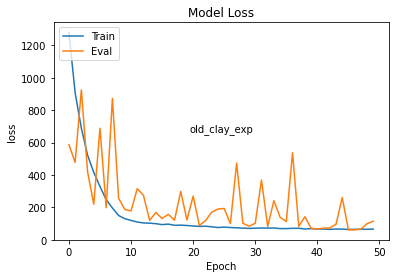

In [25]:
plt.plot(raw_history['loss'][0:EPOCH])
plt.plot(raw_history['val_loss'][0:EPOCH])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.text(0.5, 0.5, mini_EXP_name, 
         horizontalalignment = 'center', transform=plt.gca().transAxes)
plt.legend(['Train','Eval'], loc='upper left')
plt.savefig(exp_folder_path  +'/loss_.png')
plt.show()

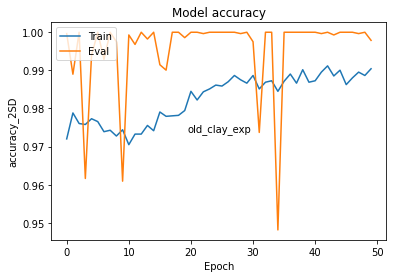

In [26]:
plt.plot(raw_history['custom_accuracy_2SD'][0:EPOCH])
plt.plot(raw_history['val_custom_accuracy_2SD'][0:EPOCH])
plt.title('Model accuracy')
plt.ylabel('accuracy_2SD')
plt.xlabel('Epoch')
plt.text(0.5, 0.5, mini_EXP_name, 
         horizontalalignment = 'center', transform=plt.gca().transAxes)
plt.legend(['Train','Eval'], loc='upper left')
plt.savefig(exp_folder_path + '/custom_accuracy_2SD.png')
plt.show()

In [27]:
files = glob.glob(exp_folder_path + '/*.hdf5',  
                   recursive = True)
saved_model = []
for file in files:
    print(file.split('/')[-1])
    saved_model.append(file.split('/')[-1])

weights-improvement-46-1.00.hdf5
weights-improvement-40-1.00.hdf5
weights-improvement-02-0.99.hdf5
weights-improvement-05-0.99.hdf5
weights-improvement-11-1.00.hdf5
weights-improvement-30-1.00.hdf5
weights-improvement-41-1.00.hdf5
weights-improvement-22-1.00.hdf5
weights-improvement-33-1.00.hdf5
weights-improvement-14-1.00.hdf5
weights-improvement-07-0.99.hdf5
weights-improvement-10-0.96.hdf5
weights-improvement-04-0.96.hdf5
weights-improvement-01-1.00.hdf5


In [29]:
# Every epoch that show improving performance will be saved. 
# weights-improvment-'Epoch'-'Eval_2SD_Accuracy'
# 'selectedE' must be updated as 'Epoch' in which 'Eval_2SD_Accuracy' is highest 

selectedE = '41'

for file in saved_model:
    if file.split('-')[-2][0:2]==str(selectedE):
        selected_weights = file
print (selected_weights)  

weights-improvement-41-1.00.hdf5


In [30]:
filepath = exp_folder_path + '/' + selected_weights 
print(filepath)

experiments/old_clay_exp/weights-improvement-41-1.00.hdf5


In [31]:
best_model = tf.keras.models.load_model(
    filepath, custom_objects = {"MSE_wSD_loss":MSE_wSD_loss, 
                                "custom_accuracy_2SD": custom_accuracy_2SD})
# best_model = tf.keras.models.load_model(filepath)
# best_model = tf.keras.models.load_model(filepath, custom_objects={"MSE_wSD_loss":MSE_wSD_loss})
# best_model = tf.keras.models.load_model(filepath)

In [32]:
#apply best model to three subset of data

##Training
train_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Train_Master, 
                                       batch_size = batch_size, 
                                       data_dir=DATA_DIR, shuffle = False)
train_label = np.hstack([batch[1][:,0] for batch in train_generator])
train_SD = np.hstack([batch[1][:,1] for batch in train_generator])
train_pred = best_model.predict(x=train_generator)

##Validation
eval_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Eval_Master, 
                                         batch_size = batch_size, 
                                         data_dir=DATA_DIR, shuffle = False)
eval_label = np.hstack([batch[1][:,0] for batch in eval_generator])
eval_SD = np.hstack([batch[1][:,1] for batch in eval_generator])
eval_pred = best_model.predict(x=eval_generator)

##Testing
test_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Test_Master, 
                                   batch_size = batch_size, 
                                   data_dir=DATA_DIR, shuffle = False)
test_label = np.hstack([batch[1][:,0] for batch in test_generator])
test_SD = np.hstack([batch[1][:,1] for batch in test_generator])
test_pred = best_model.predict(x=test_generator)

7998
7998
3064
3064
1532
1532


In [33]:
train_LSP = [train_label,train_SD,train_pred]
eval_LSP = [eval_label,eval_SD,eval_pred]
test_LSP = [test_label,test_SD,test_pred]
generator_LSP = [train_LSP,eval_LSP,test_LSP]

In [34]:
def plotting_with_TS_V(generator_LSP, mode, selected_EP):
    ## make cross plot between prediction and label with highlighted color for subset that meet threashold
    
    fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(5,12.5))

    for g, m, ax in zip(generator_LSP, mode, axs): 
        label = g[0]
        SD = g[1]
        pred = g[2].flatten()
#         if len(pred) == len(label):
#             print(len(pred))
        idx = np.abs(pred-label) > 2*SD
        error_pct = np.round(100*np.sum(idx)/len(pred), 2)
        

        ax.plot(pred, label,'o', label=f'Correct')
        ax.plot(pred[idx], label[idx], 'ro', label=f'Incorrect')
        ax.plot([0, 1], [0, 1], 'k', alpha=0.2)
        ax.set_title(str(m), fontsize = 24)
        text_error = '% error (>2SD) = ' +str(error_pct) + '%'
        ax.text(0.7, 0.1, text_error, fontsize = 12,
                horizontalalignment = 'center', transform=ax.transAxes)
        ax.legend(loc='best')
        ax.set_ylabel('Truth', fontsize =18)
    axs[2].set_xlabel('Prediction', fontsize = 18)

    plt.tight_layout()
    plt.show

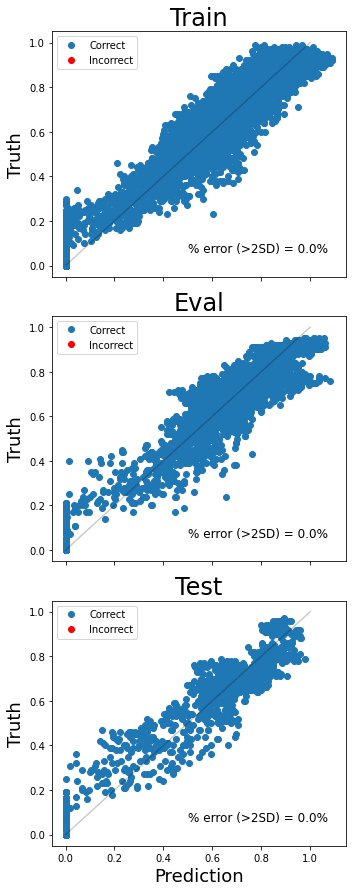

In [35]:
plotting_with_TS_V(generator_LSP, ['Train', 'Eval', 'Test'], selected_EP = selectedE)